# **CS584 NLP HW 1**
Milan Chandiramani
CWID: 20032010

In [52]:
#Importing libraries
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Task: Sentiment Analysis with Text Classification**

## Tasks 1: Extracting features (60 points)

### 1. Data preparation (20 points)

1) Data preprocessing (10 points)

In [53]:
#Load the dataset
df = pd.read_csv('amazon_reviews.csv')
df.head()

,overall,reviewText
0,4,No issues.
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."


In [54]:
df.shape

(4915, 2)

In [55]:
# Drop rows with missing data
df = df.dropna(subset=['overall', 'reviewText'])
df.shape

(4914, 2)

In [56]:
df.dtypes #check if datatype of both the columns are proper

,0
overall,int64
reviewText,object


In [57]:
df['overall'].unique()

array([4, 5, 3, 1, 2])

In [58]:
# Binary labels: Considering 3,4,5 -> Positive (1) and 1,2 -> Negative (0).
binary_df = df.copy()

binary_df['label'] = binary_df['overall'].apply(lambda x: 1 if x >= 3 else 0)
binary_df.head()

,overall,reviewText,label
0,4,No issues.,1
1,5,"Purchased this for my device, it worked as adv...",1
2,4,it works as expected. I should have sprung for...,1
3,5,This think has worked out great.Had a diff. br...,1
4,5,"Bought it with Retail Packaging, arrived legit...",1


In [59]:
binary_df[binary_df['label'] != 1].head()

,overall,reviewText,label
32,1,"I bought 2 of those SanDisk 32 GB microSD , us...",0
38,1,I bougth this micro SD card after some trubles...,0
43,1,Ordered this for a Galaxy S3. Lasted a few mo...,0
49,2,"I used this for a few months in my phone, then...",0
108,2,It works but the actual R/W speeds are 18/8 MB...,0


In [60]:
# Preprocess text: lowercase, remove punc/numbers, remove stopwords, tokenize

stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

binary_df['tokens'] = binary_df['reviewText'].apply(preprocess)
binary_df['num_tokens'] = binary_df['tokens'].apply(len)

2) Data split (5 points):

In [61]:
# Split data (0.8 / 0.1 / 0.1 train/val/test, stratified)
train, temp = train_test_split(binary_df, test_size=0.2, stratify=binary_df['label'], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)



3) Data statistics (5 points):

In [62]:
# Gather statistics
def stats(split):
    return {
        "samples": len(split),
        "positive": int((split['label'] == 1).sum()),
        "negative": int((split['label'] == 0).sum()),
        "min_tokens": int(split['num_tokens'].min()),
        "avg_tokens": float(round(split['num_tokens'].mean(), 2)),
        "max_tokens": int(split['num_tokens'].max())
    }

stats_df = pd.DataFrame(
    [stats(train), stats(val), stats(test)],
    index=['train', 'validation', 'test']
)

print(stats_df)
print(binary_df[['overall', 'reviewText', 'label', 'tokens', 'num_tokens']].head())

            samples  positive  negative  min_tokens  avg_tokens  max_tokens
train          3931      3672       259           1       25.48         781
validation      491       459        32           1       25.59         544
test            492       459        33           1       24.37         344
   overall                                         reviewText  label  \
0        4                                         No issues.      1   
1        5  Purchased this for my device, it worked as adv...      1   
2        4  it works as expected. I should have sprung for...      1   
3        5  This think has worked out great.Had a diff. br...      1   
4        5  Bought it with Retail Packaging, arrived legit...      1   

                                              tokens  num_tokens  
0                                           [issues]           1  
1  [purchased, device, worked, advertised, never,...          13  
2  [works, expected, sprung, higher, capacity, th...          

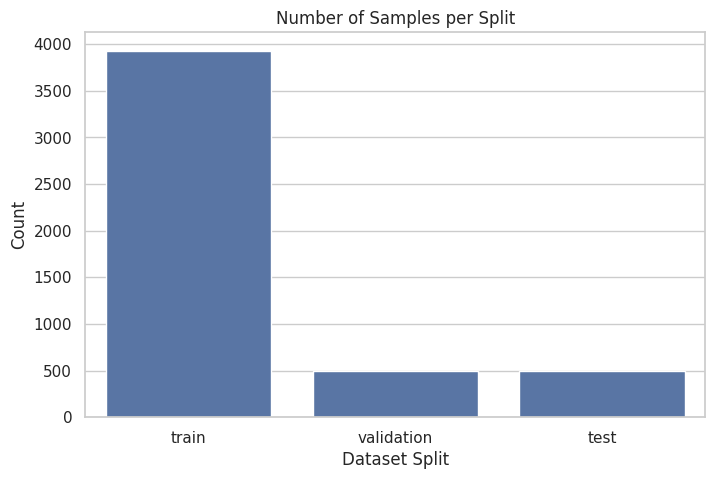

In [63]:
#Trying to plot the statistics
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Bar plot for the number of samples per split
plt.figure(figsize=(8,5))
sns.barplot(x=stats_df.index, y='samples', data=stats_df)
plt.title('Number of Samples per Split')
plt.ylabel('Count')
plt.xlabel('Dataset Split')
plt.show()

<Figure size 800x500 with 0 Axes>

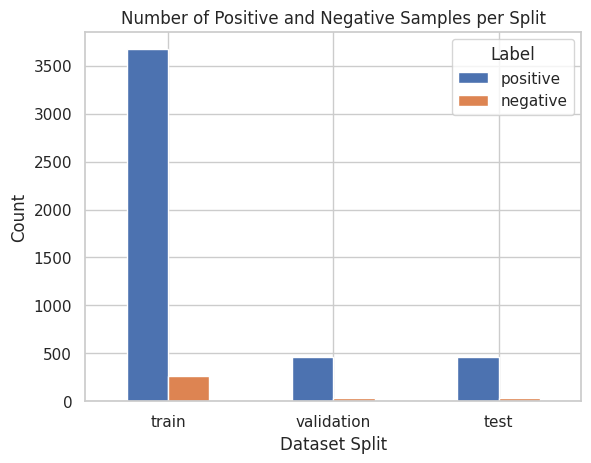

In [64]:

# Bar plot for positive vs negative samples count per split
plt.figure(figsize=(8,5))
stats_df_pos_neg = stats_df[['positive', 'negative']].copy()
stats_df_pos_neg.index = stats_df.index
stats_df_pos_neg.plot(kind='bar', stacked=False)
plt.title('Number of Positive and Negative Samples per Split')
plt.ylabel('Count')
plt.xlabel('Dataset Split')
plt.xticks(rotation=0)
plt.legend(title='Label')
plt.show()

<Figure size 1000x600 with 0 Axes>

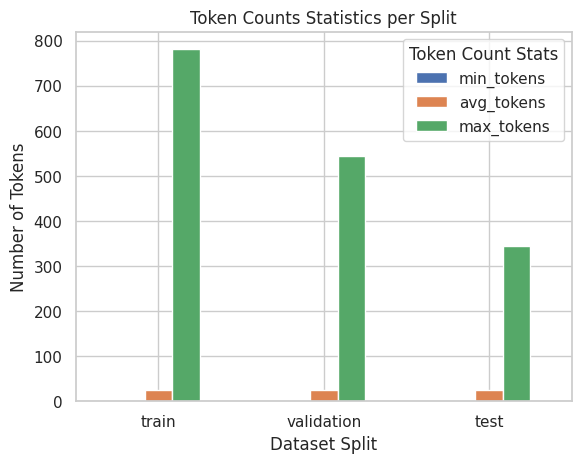

In [65]:
# Token count stats (min, avg, max) per split - grouped bar plot
plt.figure(figsize=(10,6))
token_stats = stats_df[['min_tokens', 'avg_tokens', 'max_tokens']]
token_stats.index = stats_df.index
token_stats.plot(kind='bar')
plt.title('Token Counts Statistics per Split')
plt.ylabel('Number of Tokens')
plt.xlabel('Dataset Split')
plt.xticks(rotation=0)
plt.legend(title='Token Count Stats')
plt.show()

### 2. Representation of Texts: word vectors (40 points)

1) Count-based word vectors with co-occurrence matrix (20 points, 5 points for each
question)

In [66]:
# a. Get vocabulary from corpus (list of token lists)
def get_vacab(corpus):
    # Flatten token lists and build a sorted distinct list
    all_words = set(word for tokens in corpus for word in tokens)
    all_words = sorted(all_words)
    return all_words

In [67]:
# b. Compute co-occurrence matrix for a given window size
def compute_co_occurrence_matrix(corpus, window_size=4):
    corpus_words = get_vacab(corpus)
    word2index = {word: idx for idx, word in enumerate(corpus_words)}

    vocab_size = len(corpus_words)
    M = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    # Iterate over each token list (review tokens)
    for tokens in corpus:
        token_ids = [word2index[word] for word in tokens if word in word2index]
        length = len(token_ids)
        for center_i, center_id in enumerate(token_ids):
            left = max(0, center_i - window_size)
            right = min(length, center_i + window_size + 1)
            for context_i in range(left, right):
                if context_i != center_i:
                    context_id = token_ids[context_i]
                    M[center_id, context_id] += 1
    return M, word2index

corpus = binary_df['tokens'].tolist()
M, word2index = compute_co_occurrence_matrix(corpus, window_size=4)
print(M)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [68]:
word2index

{'aac': 0,
 'aas': 1,
 'aba': 2,
 'abdroid': 3,
 'abilities': 4,
 'ability': 5,
 'able': 6,
 'aboutgood': 7,
 'abouti': 8,
 'abouttherehere': 9,
 'aboutto': 10,
 'abovei': 11,
 'abroad': 12,
 'abruptly': 13,
 'absolute': 14,
 'absolutely': 15,
 'abt': 16,
 'abuse': 17,
 'abused': 18,
 'abysmal': 19,
 'accdientally': 20,
 'accept': 21,
 'acceptable': 22,
 'acceptably': 23,
 'accepted': 24,
 'accepting': 25,
 'accepts': 26,
 'access': 27,
 'accessed': 28,
 'accesses': 29,
 'accessible': 30,
 'accessing': 31,
 'accessories': 32,
 'accessory': 33,
 'accessoryalternative': 34,
 'accident': 35,
 'accidentally': 36,
 'accidently': 37,
 'acclimated': 38,
 'accolades': 39,
 'accommodate': 40,
 'accomplish': 41,
 'accord': 42,
 'according': 43,
 'accordingly': 44,
 'account': 45,
 'accros': 46,
 'accurate': 47,
 'accuratei': 48,
 'accuratethe': 49,
 'ace': 50,
 'acer': 51,
 'acess': 52,
 'acheive': 53,
 'achieve': 54,
 'achieved': 55,
 'achievedusing': 56,
 'achieves': 57,
 'acitve': 58,
 'ackno

In [69]:
# c. Dimensionality reduction with SVD to reduce M to k dims
def reduce_to_k_dim(M, k=2):
    svd = TruncatedSVD(n_components=k, n_iter=10, random_state=42)
    M_reduced = svd.fit_transform(M)
    return M_reduced
M_reduced = reduce_to_k_dim(M, k=2)
M_reduced

array([[ 0.12846658, -0.10059098],
       [ 0.18762799, -0.03384236],
       [ 1.64781196,  1.15541128],
       ...,
       [ 1.07253206,  0.60830461],
       [ 1.27791587,  0.22853538],
       [ 0.09724572, -0.02260818]])

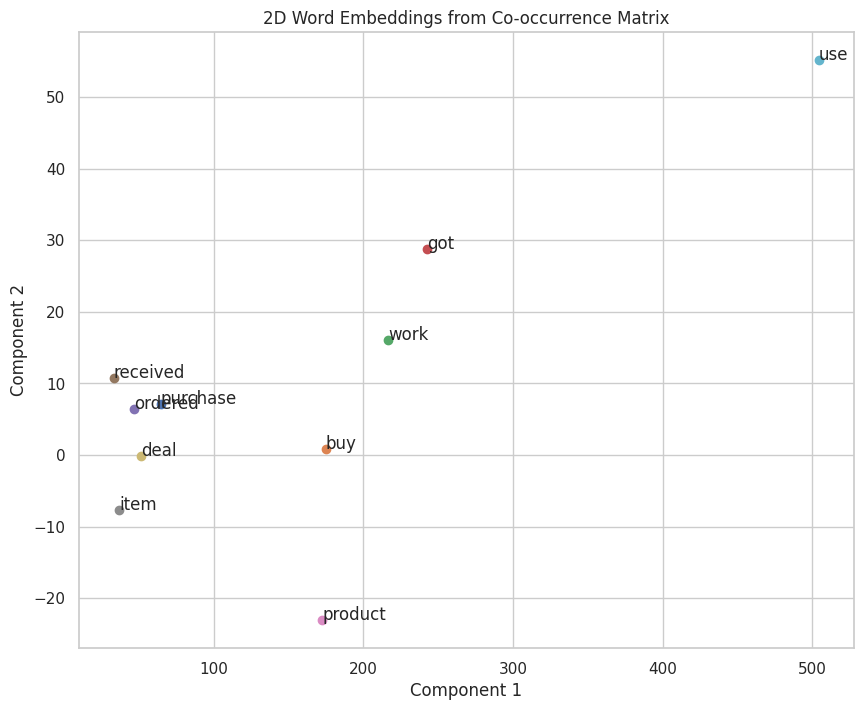

In [70]:
# d. Plot embeddings for selected words
def plot_embeddings(M_reduced, word2index, words_to_plot):
    plt.figure(figsize=(10, 8))
    for word in words_to_plot:
        if word in word2index:
            idx = word2index[word]
            x, y = M_reduced[idx, 0], M_reduced[idx, 1]
            plt.scatter(x, y)
            plt.text(x + 0.01, y + 0.01, word, fontsize=12)
    plt.title("2D Word Embeddings from Co-occurrence Matrix")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()
words_to_plot = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']
plot_embeddings(M_reduced, word2index, words_to_plot)

2) Prediction-based word vectors from Glove (20 points, 5 points for each question)

In [72]:
# Install GloVe
!pip install -U gensim

In [73]:
# a. Load GloVe embeddings with provided function
def load_embedding_model():
  """ Load GloVe Vectors
  Return:
  wv_from_bin: All 400000 embeddings, each lengh 200
  """
  import gensim.downloader as api
  wv_from_bin = api.load("glove-wiki-gigaword-200")
  print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
  return wv_from_bin
  # -----------------------------------
  # Run Cell to Load Word Vectors
  # Note: This will take a couple minutes
  # -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [74]:
# b. Select words from vocabulary and put their GloVe vectors in matrix M
import numpy as np
import random

def get_matrix_of_vectors(wv_from_bin, required_words):
    """Put the GloVe vectors into a matrix M."""
    words = list(wv_from_bin.index_to_key)
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print(f"Putting {len(words)} words into word2ind and matrix M...")
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

corpus_words = get_vacab(binary_df['tokens'].tolist())
M_glove, word2ind_glove = get_matrix_of_vectors(wv_from_bin, corpus_words)
M_glove

Putting 10000 words into word2ind and matrix M...
Done.


array([[-0.010729 , -0.023046 ,  0.34935  , ...,  0.072801 , -0.083989 ,
        -0.25194  ],
       [-0.46948  , -0.084352 , -0.27956  , ..., -0.018965 , -0.21411  ,
        -0.91731  ],
       [ 0.22785  ,  0.085184 ,  0.0035642, ...,  0.061208 ,  0.10439  ,
        -0.90203  ],
       ...,
       [-0.55794  , -0.15971  ,  0.068403 , ..., -0.15635  ,  0.11359  ,
         0.47554  ],
       [ 0.4385   , -0.64002  , -0.70505  , ...,  0.0046388, -0.0224   ,
         0.13018  ],
       [-0.35548  ,  0.22649  , -0.37089  , ..., -0.062321 ,  0.19923  ,
        -0.15657  ]], dtype=float32)

In [75]:
word2ind_glove

{'period_8': 0,
 'soma': 1,
 'shaeffer': 2,
 'kdom': 3,
 'catchings': 4,
 'geebung': 5,
 'ynys': 6,
 'edta': 7,
 'exoskeleton': 8,
 'sligo': 9,
 'guttie': 10,
 'monda': 11,
 'tyube': 12,
 '58.11': 13,
 '203.3': 14,
 'taler': 15,
 'universidad': 16,
 'fifth': 17,
 'unido': 18,
 '1stld': 19,
 'dumri': 20,
 'saruman': 21,
 'szkutak': 22,
 'konolfingen': 23,
 'shayan': 24,
 'rideable': 25,
 'blatant': 26,
 'ljungskog': 27,
 'ezer': 28,
 'masterson': 29,
 'whipsawing': 30,
 'part-of-speech': 31,
 'foie': 32,
 'preparing': 33,
 'sperryville': 34,
 '.100': 35,
 'grobari': 36,
 'hatsopoulos': 37,
 'railhawks': 38,
 'bienert': 39,
 'noreste': 40,
 'vieweg': 41,
 'allusions/references': 42,
 '0m': 43,
 'busbridge': 44,
 'mitko': 45,
 'faraji': 46,
 'caption': 47,
 'sanchi': 48,
 'enviro400': 49,
 '23.22': 50,
 'nadaun': 51,
 'a58': 52,
 'taraxacum': 53,
 '1,752': 54,
 'copd': 55,
 'kakuma': 56,
 'fushe': 57,
 'keaten': 58,
 'auriculata': 59,
 'rack-mounted': 60,
 'uli': 61,
 'u.s.-registered': 6

In [76]:
# c. Reduce GloVe vectors to 2D using the reduce_to_k_dim function from Part 1)c
M_glove_reduced = reduce_to_k_dim(M_glove, k=2)

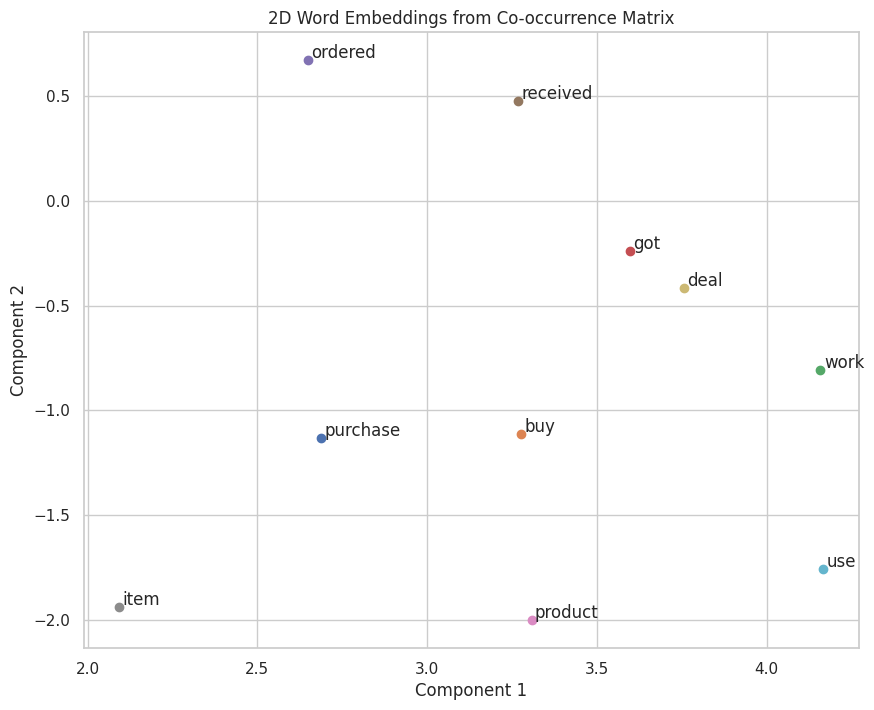

In [77]:
# d. Use plot_embeddings from Part 1)d to plot the same set of words
words_to_plot = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']
plot_embeddings(M_glove_reduced, word2ind_glove, words_to_plot)

**ANALYSIS:**
The GloVe embeddings are trained on a massive corpus to capture semantic relationships, so in the reduced 2D space, words which are synonyms group closely.
The co-occurrence matrix embeddings from the dataset are simpler counts-based vector and capture only immediate neighborhood statistics; their clusters might be more sparse or less meaningful.
Differences between these plots highlight the richer, denser correlations captured by prediction-based embeddings vs count-based.
Also, I found it interesting that ordered and received are much more closer to each other in the count-based but have roughly same distance as purchase and buy in the GloVe dataset


## Task 2: Sentiment Classification Algorithms (40 points)

In [78]:
# Imports needed for Task 2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import TruncatedSVD

### 3. Perform sentiment analysis with classification

In [79]:
# 1) Review embeddings from word embeddings using average (reduce_to_k_dim from 1)c used here)
def get_review_embedding(review_tokens, word2index, M_reduced):
    # Average word vectors for tokens present in word2index
    vecs = [M_reduced[word2index[word]] for word in review_tokens if word in word2index]
    if len(vecs) > 0:
        return np.mean(vecs, axis=0)
    else:
        # If no tokens present, return zero vector
        return np.zeros(M_reduced.shape[1])

In [80]:
def all_review_embeddings(corpus, word2index, M_reduced):
    return np.vstack([get_review_embedding(tokens, word2index, M_reduced) for tokens in corpus])

In [81]:
# Since we have binary_df, with train/val/test splits: train, val, test DataFrames with tokens, label
corpus_train = train['tokens'].tolist()
corpus_val = val['tokens'].tolist()
corpus_test = test['tokens'].tolist()

In [82]:
M_128 = reduce_to_k_dim(M, k=128)  # M is glove matrix earlier computed

In [83]:
X_train = all_review_embeddings(corpus_train, word2index, M_128)
X_val = all_review_embeddings(corpus_val, word2index, M_128)
X_test = all_review_embeddings(corpus_test, word2index, M_128)

y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

In [84]:
# 2) Scale data for models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [85]:
# 2) a. Logistic Regression model with L2 regularization (10 points)
logreg = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_val_pred = logreg.predict(X_val_scaled)
y_val_prob = logreg.predict_proba(X_val_scaled)[:,1]

In [86]:
# Evaluate validation performance
val_acc = accuracy_score(y_val, y_val_pred)
val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')
val_auc = roc_auc_score(y_val, y_val_prob)

In [87]:
print("Logistic Regression")
print(f"Validation Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

Logistic Regression
Validation Accuracy: 0.9491, Precision: 0.9597, Recall: 0.9869, F1: 0.9731, AUC: 0.9530


In [88]:
# 2) b. A Neural Network (NN) model for sentiment classification (10 points)
# Did a simple Perceptron :)
class SentimentNet(nn.Module):
    def __init__(self, input_dim):
        super(SentimentNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

input_dim = X_train_scaled.shape[1]
model = SentimentNet(input_dim)

In [89]:
# Convert data to torch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [90]:
# Training loop
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

In [91]:
# Validation evaluation
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor).squeeze()
    val_pred = (val_outputs >= 0.5).int().numpy()
    val_prob = val_outputs.numpy()

val_acc_nn = accuracy_score(y_val, val_pred)
val_prec_nn, val_rec_nn, val_f1_nn, _ = precision_recall_fscore_support(y_val, val_pred, average='binary')
val_auc_nn = roc_auc_score(y_val, val_prob)

print(f"Neural Network Validation Accuracy: {val_acc_nn:.4f}, Precision: {val_prec_nn:.4f}, Recall: {val_rec_nn:.4f}, F1: {val_f1_nn:.4f}, AUC: {val_auc_nn:.4f}")

Neural Network Validation Accuracy: 0.9593, Precision: 0.9621, Recall: 0.9956, F1: 0.9786, AUC: 0.9542


In [92]:
# 3)a. So far we checked validation statistics. Now, we will evaluate model on test set (choose best from val)
# Logistic Regression test
y_test_pred = logreg.predict(X_test_scaled)
y_test_prob = logreg.predict_proba(X_test_scaled)[:,1]

test_acc = accuracy_score(y_test, y_test_pred)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')
test_auc = roc_auc_score(y_test, y_test_prob)

print(f"Logistic Regression Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

Logistic Regression Test Accuracy: 0.9350, Precision: 0.9572, Recall: 0.9739, F1: 0.9654, AUC: 0.9253


In [93]:

# Neural Network test
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_pred = (test_outputs >= 0.5).int().numpy()
    test_prob = test_outputs.numpy()

test_acc_nn = accuracy_score(y_test, test_pred)
test_prec_nn, test_rec_nn, test_f1_nn, _ = precision_recall_fscore_support(y_test, test_pred, average='binary')
test_auc_nn = roc_auc_score(y_test, test_prob)

print(f"Neural Network Test Accuracy: {test_acc_nn:.4f}, Precision: {test_prec_nn:.4f}, Recall: {test_rec_nn:.4f}, F1: {test_f1_nn:.4f}, AUC: {test_auc_nn:.4f}")

Neural Network Test Accuracy: 0.9533, Precision: 0.9599, Recall: 0.9913, F1: 0.9753, AUC: 0.9129


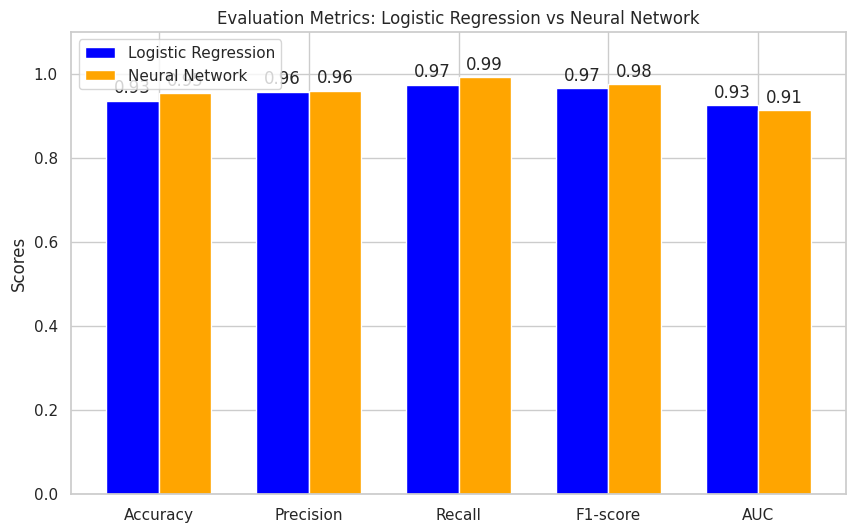

In [94]:
# Comparing both logreg and nn for test data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
logreg_scores = [test_acc, test_prec, test_rec, test_f1, test_auc]
nn_scores = [test_acc_nn, test_prec_nn, test_rec_nn, test_f1_nn, test_auc_nn]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width/2, logreg_scores, width, label='Logistic Regression', color='blue')
bars2 = ax.bar(x + width/2, nn_scores, width, label='Neural Network', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics: Logistic Regression vs Neural Network')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar displaying its height
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.ylim(0, 1.1)
plt.show()


3) b. Have a brief discussion to compare the performance of those two models (5 points). It
should be noted that there is no fixed answer for the results. You will need to report the
exact results returned in your experiments. The discussions should only base on your
own experimental settings and returned results.

Discussion:
- Logistic regression provides a strong baseline and converges quickly.
- Neural network with one hidden layer may capture nonlinearities and interactions better, potentially leading to slight improvements in precision, recall, or F1-score.
- As seen above, results are quite similar as we are comparing Log Reg with a simple NN.
- Performance depends on embedding quality and hyperparameter tuning. Also, we get a very high evaluation such as high accuracy, precision, recall,... as the dataset is very unbalanced as seen in Task 1 1.3) Data Statistics Plot and many reviews are positive since I have taken 3,4 and 5 as positive ratings and 1,2 as negative ratings
- It is surprising to see such high accuracy since I thought some of the data won't be very helpful such as:
Review : No Issues , Rating : 4 (1/Positive)
Above data sample after stopword removal becomes:
Review : Issues , Rating : 4 (1/Positive)

I thought such examples will make a negative connotation for output but since dataset is highly unbalanced, however, you still see good metrics.

## Task 3. Self-Reflection (5 points)

This question is required in the submission to help you assess your understanding of the related topics and identify the areas for further improvement and set goals accordingly.

It also promotes communication between you and the instructor and will further improve the course development and learning experience.
Question Answers
(provide the answer index)


Q1: Rate your performance


4-Somewhat satisfied

Q2: How much does your understanding of the concepts influence
your performance?


5-Very important

Q3: How much does the design of the examples/questions (is relatable
to you) influence your performance?

4-Somewhat important

Q4: When you answer Q3, which are the primary factors influencing
the relatability of the examples to you?

3-Age

6- Hobbies and interests

7- Prior knowledge about the context in the example